In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style="whitegrid", context="talk")

In [2]:
train = pd.read_csv('favorita-grocery-sales-forecasting/train.csv/train.csv')
print(train.head())

C:\Users\Dell\AppData\Local\Temp\ipykernel_17288\2374804111.py:1: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv('favorita-grocery-sales-forecasting/train.csv/train.csv')


   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN


In [3]:
test_path = 'favorita-grocery-sales-forecasting/test.csv/test.csv'
transactions_path = 'favorita-grocery-sales-forecasting/transactions.csv/transactions.csv'
holidays_path = 'favorita-grocery-sales-forecasting/holidays_events.csv/holidays_events.csv'
items_path = 'favorita-grocery-sales-forecasting/items.csv/items.csv'
oil_path = 'favorita-grocery-sales-forecasting/oil.csv/oil.csv'
stores_path = 'favorita-grocery-sales-forecasting/stores.csv/stores.csv'

In [4]:
# Load the datasets
test = pd.read_csv(test_path)
transactions = pd.read_csv(transactions_path)
holidays = pd.read_csv(holidays_path)
items = pd.read_csv(items_path)
oil = pd.read_csv(oil_path)
stores = pd.read_csv(stores_path)

In [5]:
print("Train:", train.shape)
print("Test:", test.shape)
print("Transactions:", transactions.shape)
print("Holidays:", holidays.shape)
print("Items:", items.shape)
print("Oil:", oil.shape)
print("Stores:", stores.shape)

Train: (125497040, 6)
Test: (3370464, 5)
Transactions: (83488, 3)
Holidays: (350, 6)
Items: (4100, 4)
Oil: (1218, 2)
Stores: (54, 5)


## Data Preprocessing and EDA 

##### Train Dataset

In [6]:
print("Initial Train Data:")
print(train.head())
print("\nData Info:")
print(train.info())

Initial Train Data:
   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125497040 entries, 0 to 125497039
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   item_nbr     int64  
 4   unit_sales   float64
 5   onpromotion  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 5.6+ GB
None


In [7]:
print(train.describe())

                 id     store_nbr      item_nbr    unit_sales
count  1.254970e+08  1.254970e+08  1.254970e+08  1.254970e+08
mean   6.274852e+07  2.746458e+01  9.727692e+05  8.554865e+00
std    3.622788e+07  1.633051e+01  5.205336e+05  2.360515e+01
min    0.000000e+00  1.000000e+00  9.699500e+04 -1.537200e+04
25%    3.137426e+07  1.200000e+01  5.223830e+05  2.000000e+00
50%    6.274852e+07  2.800000e+01  9.595000e+05  4.000000e+00
75%    9.412278e+07  4.300000e+01  1.354380e+06  9.000000e+00
max    1.254970e+08  5.400000e+01  2.127114e+06  8.944000e+04


In [8]:
# Convert the 'date' column from object to datetime type
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')
print("\nAfter converting 'date' column:")
print(train['date'].dtype)


After converting 'date' column:
datetime64[ns]


In [9]:
# Drop the 'onpromotion' column since it is not needed for this analysis
train = train.drop(columns=['onpromotion'])
print("\nColumns after dropping 'onpromotion':", train.columns.tolist())


Columns after dropping 'onpromotion': ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales']


In [10]:
print("Missing values in train:\n", train.isnull().sum())

Missing values in train:
 id            0
date          0
store_nbr     0
item_nbr      0
unit_sales    0
dtype: int64


Univariate Analysis

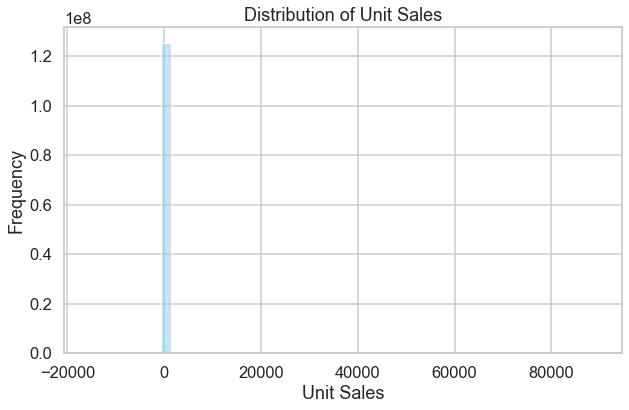

In [11]:
#  Distribution of 'unit_sales'
plt.figure(figsize=(10, 6))
sns.histplot(train['unit_sales'], bins=50, kde=True, color='skyblue')
plt.title('Distribution of Unit Sales')
plt.xlabel('Unit Sales')
plt.ylabel('Frequency')
plt.show()

In [12]:
print("\nUnit Sales Summary Statistics:")
print(train['unit_sales'].describe())


Unit Sales Summary Statistics:


count    1.254970e+08
mean     8.554865e+00
std      2.360515e+01
min     -1.537200e+04
25%      2.000000e+00
50%      4.000000e+00
75%      9.000000e+00
max      8.944000e+04
Name: unit_sales, dtype: float64


The mean (
≈
8.55
≈8.55) is larger than the median (4), and the maximum is 
89,440
89,440. This suggests a right-skewed (long-tailed) distribution where a relatively small number of records have very high unit_sales.

 Bivariate Analysis

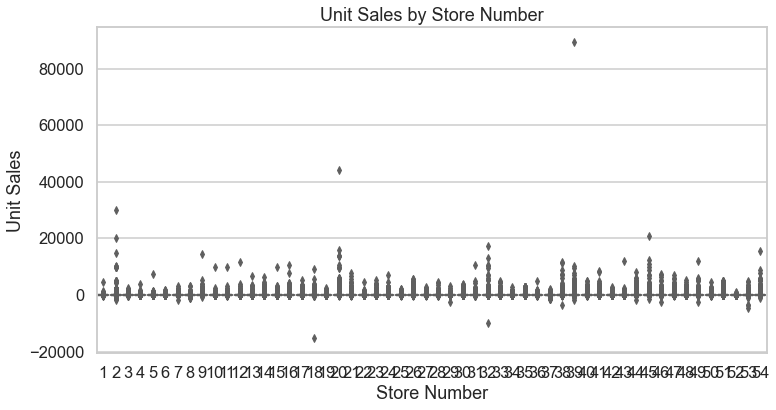

In [13]:
# Unit Sales vs. Store Number (Boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_nbr', y='unit_sales', data=train, palette='Set3')
plt.title('Unit Sales by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Unit Sales')
plt.show()

 Shows that unit sales vary greatly across stores with several outliers, indicating high variability or returns.

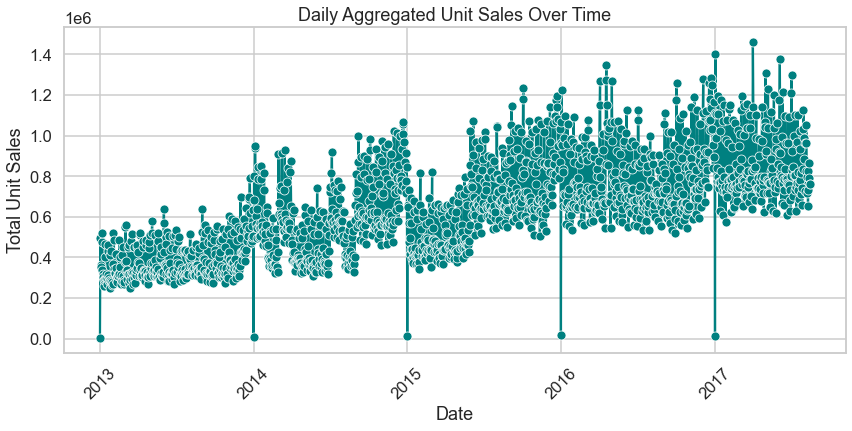

In [14]:
# Unit Sales Over Time (Daily Aggregated Sales)
daily_sales = train.groupby('date')['unit_sales'].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(x='date', y='unit_sales', data=daily_sales, marker='o', color='teal')
plt.title('Daily Aggregated Unit Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Total Unit Sales')
plt.xticks(rotation=45)
plt.show()

Reveals a generally increasing trend with noticeable spikes, suggesting seasonal or event-driven effects.

Multivariate Analysis

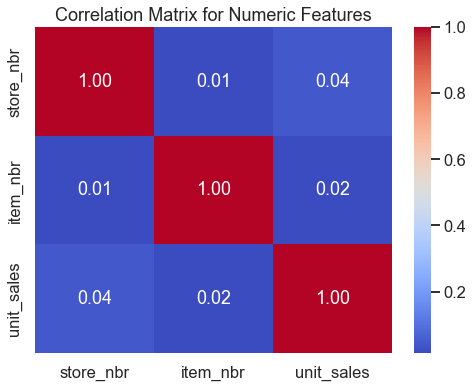

In [15]:
# Correlation Matrix for Numeric Features
numeric_features = ['store_nbr', 'item_nbr', 'unit_sales']
corr_matrix = train[numeric_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Numeric Features')
plt.show()


Indicates weak correlation between store/item IDs and unit_sales, pointing to the need for additional features.

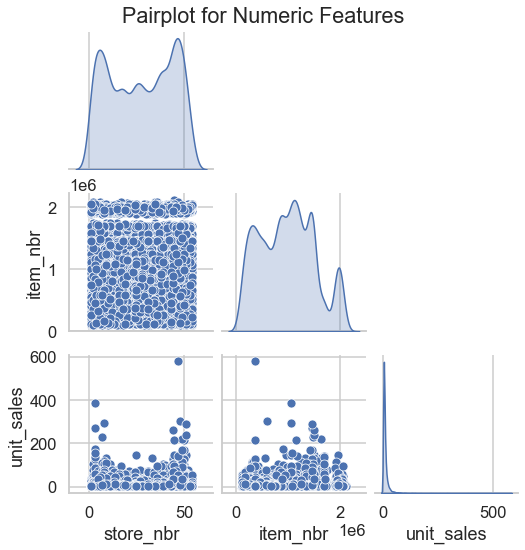

In [16]:
#  Pairplot for Numeric Features (sampling if the dataset is large)
sample_size = 10000  # Sample size for pairplot
if train.shape[0] > sample_size:
    sampled_train = train.sample(n=sample_size, random_state=42)
else:
    sampled_train = train.copy()

sns.pairplot(sampled_train[numeric_features], diag_kind='kde', corner=True)
plt.suptitle('Pairplot for Numeric Features', y=1.02)
plt.show()

Highlights minimal pairwise relationships and a heavily skewed distribution of unit_sales.

Test Dataset

In [17]:
test.isna().sum()

id             0
date           0
store_nbr      0
item_nbr       0
onpromotion    0
dtype: int64

In [18]:
test.head()

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


In [19]:
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')
print("Test Data Info:")
print(test.info())

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB
None


In [20]:
# Convert date to datetime
print(test.info())
print(test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3370464 entries, 0 to 3370463
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   onpromotion  bool          
dtypes: bool(1), datetime64[ns](1), int64(3)
memory usage: 106.1 MB
None
          id       date  store_nbr  item_nbr  onpromotion
0  125497040 2017-08-16          1     96995        False
1  125497041 2017-08-16          1     99197        False
2  125497042 2017-08-16          1    103501        False
3  125497043 2017-08-16          1    103520        False
4  125497044 2017-08-16          1    103665        False


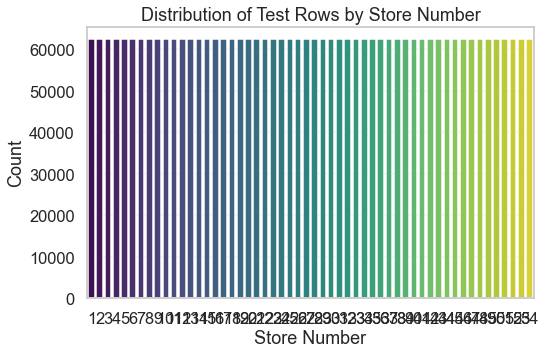

In [21]:
# Distribution of Store Numbers in Test Data
plt.figure(figsize=(8, 5))
sns.countplot(x='store_nbr', data=test, palette='viridis')
plt.title('Distribution of Test Rows by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Count')
plt.show()

Each store has a similar number of rows in the test set, suggesting a uniform distribution across stores.

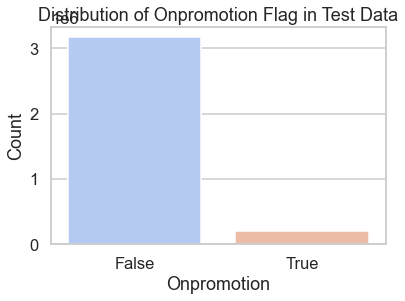

In [22]:
# Distribution of Onpromotion Flag
plt.figure(figsize=(6, 4))
sns.countplot(x='onpromotion', data=test, palette='coolwarm')
plt.title('Distribution of Onpromotion Flag in Test Data')
plt.xlabel('Onpromotion')
plt.ylabel('Count')
plt.show()

Most items in the test set are not on promotion, with only a small proportion marked as True.

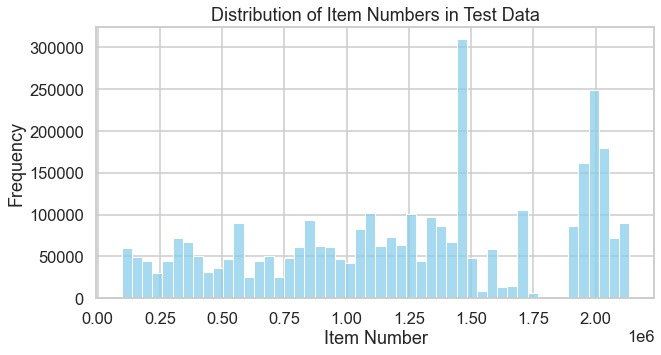

In [23]:
# Distribution of Item Numbers (as a proxy to check frequency)
plt.figure(figsize=(10, 5))
sns.histplot(test['item_nbr'], bins=50, kde=False, color='skyblue')
plt.title('Distribution of Item Numbers in Test Data')
plt.xlabel('Item Number')
plt.ylabel('Frequency')
plt.show()

Item numbers span a wide range with certain peaks, indicating more frequent appearances of specific item ID blocks.

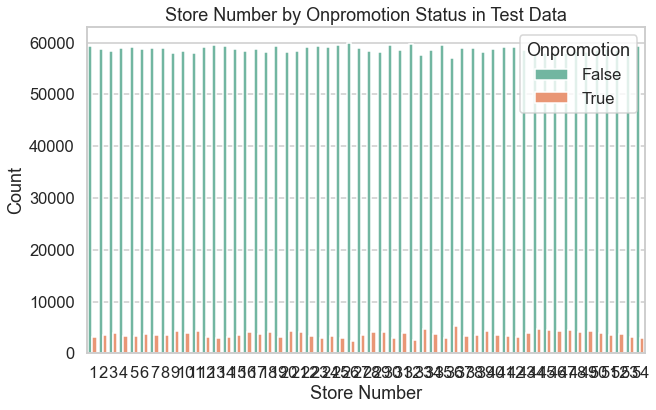

In [24]:
#  Onpromotion vs. Store Number (Grouped Count)
plt.figure(figsize=(10, 6))
sns.countplot(x='store_nbr', hue='onpromotion', data=test, palette='Set2')
plt.title('Store Number by Onpromotion Status in Test Data')
plt.xlabel('Store Number')
plt.ylabel('Count')
plt.legend(title='Onpromotion')
plt.show()

Every store has mostly non-promoted items, though a small fraction of each store’s items are on promotion.

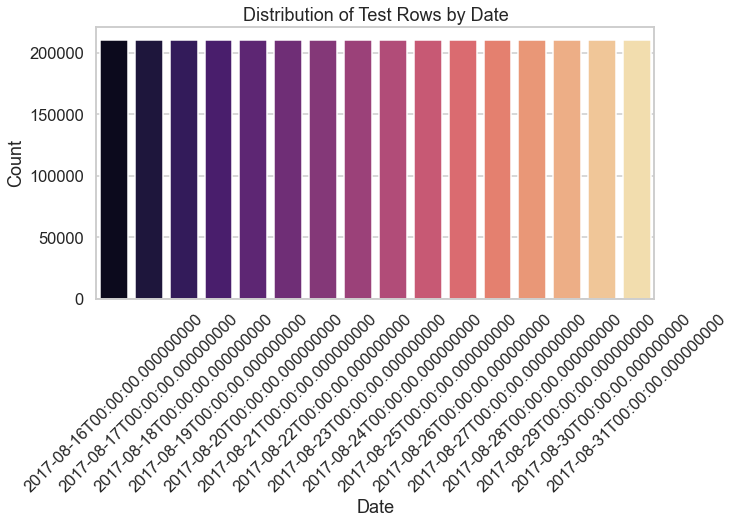

In [25]:
# (b) Date Distribution (if multiple dates exist; here sample shows a single date, but code is provided for extensibility)
plt.figure(figsize=(10, 5))
sns.countplot(x='date', data=test, palette='magma')
plt.title('Distribution of Test Rows by Date')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

Test rows are spread fairly evenly across the specified date range in August 2017, with each date having a similar volume of records.

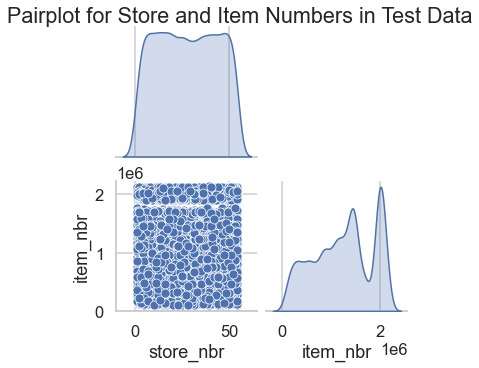

In [26]:
# 4. Multivariate Analysis
# Pairplot for Test Data (Using a sample if dataset is large)
sample_size = 10000
if test.shape[0] > sample_size:
    test_sample = test.sample(n=sample_size, random_state=42)
else:
    test_sample = test.copy()

sns.pairplot(test_sample[['store_nbr', 'item_nbr']], diag_kind='kde', corner=True)
plt.suptitle('Pairplot for Store and Item Numbers in Test Data', y=1.02)
plt.show()

Store and item IDs exhibit no direct relationship, reflecting their roles as identifiers rather than numerical predictors.

Transactions Dataset

In [27]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [28]:
print(transactions.info())
print(transactions.describe())
print("Missing values in transactions:\n", transactions.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB
None
          store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000
Missing values in transactions:
 date            0
store_nbr       0
transactions    0
dtype: int64


In [29]:
transactions['date'] = pd.to_datetime(transactions['date'], format='%Y-%m-%d')
print("\nAfter converting 'date' to datetime:")
print(transactions['date'].dtype)


After converting 'date' to datetime:
datetime64[ns]


In [30]:
print("\nSummary statistics for transactions:")
print(transactions.describe())


Summary statistics for transactions:
          store_nbr  transactions
count  83488.000000  83488.000000
mean      26.939237   1694.602158
std       15.608204    963.286644
min        1.000000      5.000000
25%       13.000000   1046.000000
50%       27.000000   1393.000000
75%       40.000000   2079.000000
max       54.000000   8359.000000


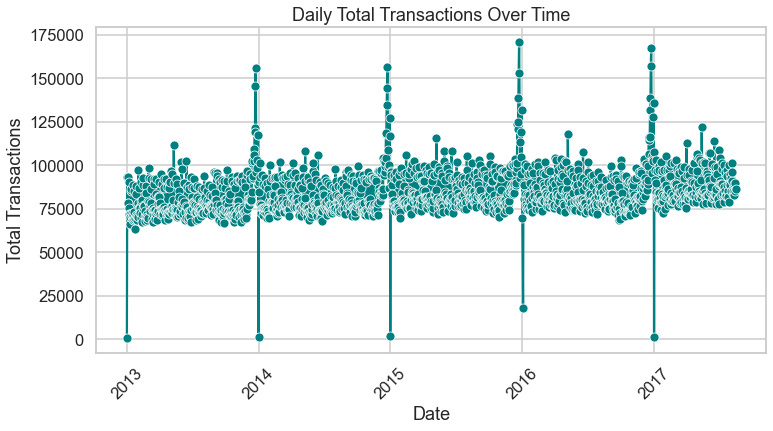

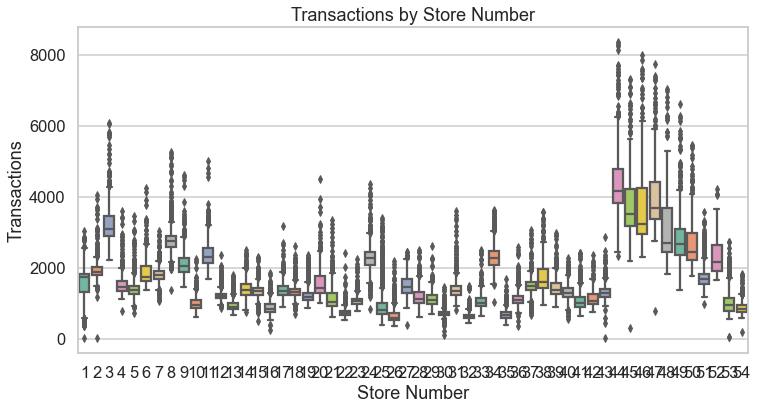

In [31]:
plt.figure(figsize=(12, 6))
daily_transactions = transactions.groupby('date')['transactions'].sum().reset_index()
sns.lineplot(x='date', y='transactions', data=daily_transactions, marker='o', color='teal')
plt.title('Daily Total Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Total Transactions')
plt.xticks(rotation=45)
plt.show()

# 5. Plotting transactions by store (boxplot)
plt.figure(figsize=(12, 6))
sns.boxplot(x='store_nbr', y='transactions', data=transactions, palette='Set2')
plt.title('Transactions by Store Number')
plt.xlabel('Store Number')
plt.ylabel('Transactions')
plt.show()

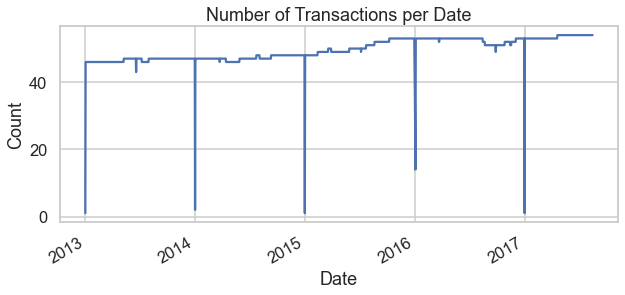

In [32]:
# Plot transaction counts over time (if date is available)
if 'date' in transactions.columns:
    transactions['date'] = pd.to_datetime(transactions['date'])
    plt.figure(figsize=(10, 4))
    transactions.groupby('date').size().plot()
    plt.title('Number of Transactions per Date')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

Holidays Dataset

In [33]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [34]:
print(holidays.info())
print(holidays.head())
print(holidays.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB
None
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1   

In [35]:
holidays['date'] = pd.to_datetime(holidays['date'], format='%Y-%m-%d')
print("\nAfter converting 'date' column:", holidays['date'].dtype)


After converting 'date' column: datetime64[ns]


In [36]:
print("\nMissing values in holidays dataset:")
print(holidays.isnull().sum())


Missing values in holidays dataset:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


In [37]:
print("\nUnique 'type' values:", holidays['type'].unique())
print("Unique 'locale' values:", holidays['locale'].unique())
print("Unique 'locale_name' values:", holidays['locale_name'].unique())


Unique 'type' values: ['Holiday' 'Transfer' 'Additional' 'Bridge' 'Work Day' 'Event']
Unique 'locale' values: ['Local' 'Regional' 'National']
Unique 'locale_name' values: ['Manta' 'Cotopaxi' 'Cuenca' 'Libertad' 'Riobamba' 'Puyo' 'Guaranda'
 'Imbabura' 'Latacunga' 'Machala' 'Santo Domingo' 'El Carmen' 'Cayambe'
 'Esmeraldas' 'Ecuador' 'Ambato' 'Ibarra' 'Quevedo'
 'Santo Domingo de los Tsachilas' 'Santa Elena' 'Quito' 'Loja' 'Salinas'
 'Guayaquil']


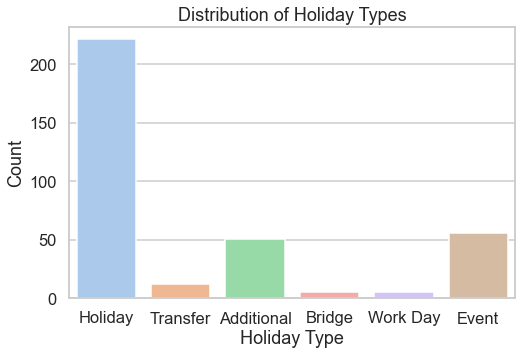

In [38]:
# Plot the distribution of holiday types
plt.figure(figsize=(8, 5))
sns.countplot(x='type', data=holidays, palette='pastel')
plt.title('Distribution of Holiday Types')
plt.xlabel('Holiday Type')
plt.ylabel('Count')
plt.show()


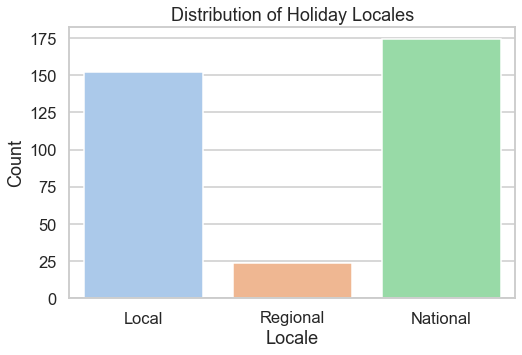

In [39]:
# Plot the distribution of locales (e.g., Local, Regional, National)
plt.figure(figsize=(8, 5))
sns.countplot(x='locale', data=holidays, palette='pastel')
plt.title('Distribution of Holiday Locales')
plt.xlabel('Locale')
plt.ylabel('Count')
plt.show()

In [40]:
holidays['is_holiday'] = 1

In [41]:
print("\nProcessed Holidays Data:")
print(holidays.head())


Processed Holidays Data:
        date     type    locale locale_name                    description  \
0 2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1 2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2 2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3 2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4 2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  is_holiday  
0        False           1  
1        False           1  
2        False           1  
3        False           1  
4        False           1  


Stores Dataset

In [42]:
stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [43]:
print("Initial Stores Data Info:")
print(stores.info())
print("\nFirst 5 rows of Stores Data:")
print(stores.head())

Initial Stores Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB
None

First 5 rows of Stores Data:
   store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4


In [44]:
missing_values = stores.isnull().sum()
print("\nMissing values in stores dataset:")
print(missing_values)


Missing values in stores dataset:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


In [45]:
print(stores.dtypes)


store_nbr     int64
city         object
state        object
type         object
cluster       int64
dtype: object


In [46]:
stores['store_nbr'] = stores['store_nbr'].astype(int)
stores['cluster'] = stores['cluster'].astype(int)

In [47]:
print(stores.dtypes)

store_nbr     int32
city         object
state        object
type         object
cluster       int32
dtype: object


In [48]:
print(stores[['store_nbr', 'cluster']].describe())

       store_nbr    cluster
count  54.000000  54.000000
mean   27.500000   8.481481
std    15.732133   4.693395
min     1.000000   1.000000
25%    14.250000   4.000000
50%    27.500000   8.500000
75%    40.750000  13.000000
max    54.000000  17.000000


Oil Dataset

In [49]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


In [50]:
print(oil.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB
None


In [51]:
oil['date'] = pd.to_datetime(oil['date'], format='%Y-%m-%d')
print("\nData type of 'date' after conversion:", oil['date'].dtype)


Data type of 'date' after conversion: datetime64[ns]


In [52]:
missing_count = oil['dcoilwtico'].isnull().sum()
print("\nMissing values in 'dcoilwtico' before handling:", missing_count)


Missing values in 'dcoilwtico' before handling: 43


In [53]:
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [54]:
missing_count_after = oil['dcoilwtico'].isnull().sum()
print("Missing values in 'dcoilwtico' after interpolation:", missing_count_after)

Missing values in 'dcoilwtico' after interpolation: 1


In [55]:
oil['dcoilwtico'].describe()

count    1217.000000
mean       67.661824
std        25.633068
min        26.190000
25%        46.410000
50%        53.180000
75%        95.710000
max       110.620000
Name: dcoilwtico, dtype: float64

## Merging Datasets

In [ ]:
final_df = train.merge(stores, on='store_nbr', how='left')
final_df = final_df.merge(items, on='item_nbr', how='left')

avg_sales = final_df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].mean().reset_index()
avg_sales.rename(columns={'unit_sales': 'avg_unit_sales'}, inplace=True)

final_df = final_df.merge(avg_sales, on=['store_nbr', 'item_nbr'], how='left')

final_columns = [
    'id', 'date', 'store_nbr', 'item_nbr', 'unit_sales',
    'city', 'state', 'type', 'cluster', 'family', 'class', 'perishable',
    'avg_unit_sales'
]
final_dataset = final_df[final_columns]

final_dataset.to_csv('final_train_dataset.csv', index=False)
print("Final dataset saved with columns:", final_columns)

Final dataset saved with columns: ['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'city', 'state', 'type', 'cluster', 'family', 'class', 'perishable', 'avg_unit_sales']
